Github link: https://github.com/genom10/Sensors2023/tree/master/HW5

# Task 5.1

In [141]:
# !pip install sklearn
# !pip install open3d

## Generate noisy data

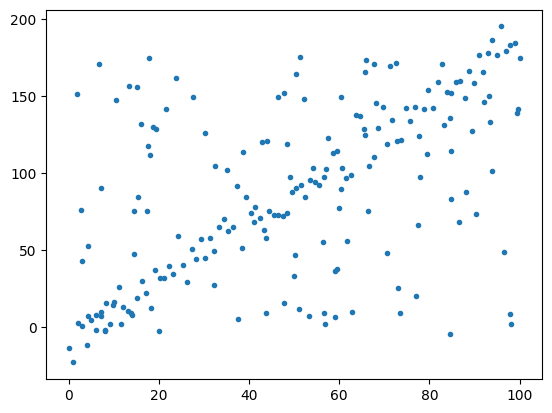

In [142]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    try:
        return x*2-10 + np.random.normal(scale=10, size=len(x))
    except:
        return x*2-10 + np.random.normal(scale=10)

X = np.linspace(0, 100, 100)
Y = f(X)

noizedX = np.append(X, np.random.uniform(low=0, high=100, size = 100))
noizedY = np.append(Y, np.random.uniform(low=f(0), high=f(100), size = 100))

plt.plot(noizedX, noizedY, '.')

## use RANSAC from `sklearn.linear_models`

In [143]:
x = noizedX.reshape(-1, 1)
y = noizedY.reshape(-1, 1)

In [144]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()
ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [145]:
line_x_ransac = np.array([x.min(), x.max()])
line_y_ransac = ransac.predict(line_x_ransac.reshape(-1, 1)).T
line_ransac = np.vstack((line_x_ransac, line_y_ransac))
print(line_ransac)

[[  0.         100.        ]
 [ -7.65054745 186.24915988]]


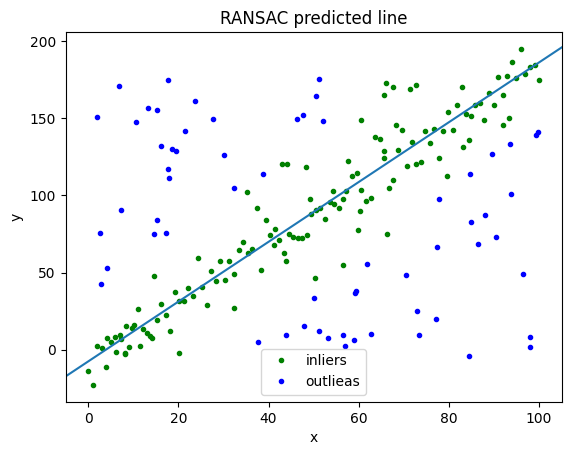

In [146]:
plt.title('RANSAC predicted line')
plt.plot(x[inlier_mask], y[inlier_mask], 'og', markersize=3, label='inliers')
plt.plot(x[outlier_mask], y[outlier_mask], 'ob', markersize=3, label='outlieas')
plt.axline(*(line_ransac.T))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Task 5.2

## Load cloud of points

Reference model: https://github.com/genom10/Sensors2023/tree/master/HW5/ObjectRecognition.blend

Point cloud: https://github.com/genom10/Sensors2023/tree/master/HW5/Suzan.ply

In [147]:
import open3d as o3d
pcd = o3d.io.read_point_cloud('Suzan.ply')
o3d.visualization.draw_geometries([pcd])

In case `object3d` is not installed:

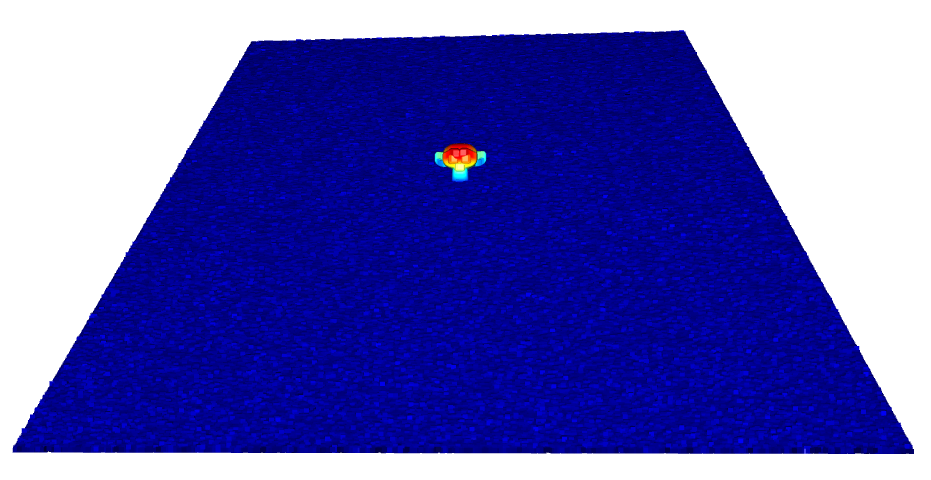

In [148]:
cloud = np.asarray(pcd.points)
cloud.shape

(294827, 3)

## Detect floor

In [149]:
print(f'x min:{min(cloud[:,0])}\tmax:{max(cloud[:,0])}')
print(f'y min:{min(cloud[:,1])}\tmax:{max(cloud[:,2])}')
print(f'z min:{min(cloud[:,2])}\tmax:{max(cloud[:,2])}')

x min:-16.428300857543945	max:16.428302764892578
y min:-16.428302764892578	max:0.6397667527198792
z min:-0.9656639099121094	max:0.6397667527198792


In [150]:
xy, z = cloud[:, :2], cloud[:, 2]
print(xy.shape)
print(z.shape)

(294827, 2)
(294827,)


In [151]:
ransac = RANSACRegressor(residual_threshold=0.145) # higher number -> more points regarded as part of he floor
ransac.fit(xy, z)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
ransac.score(xy, z)

-0.09398028215455945

In [152]:
inliers_color = np.array([0, 1, 0.2])
outliers_color = np.array([0.1, 0, 1])

pointColor = np.zeros_like(cloud)
pointColor[inlier_mask, :] = inliers_color
pointColor[outlier_mask, :] = outliers_color

## Visualize classification of the points

In [153]:
pc_result = o3d.geometry.PointCloud()
pc_result.points = o3d.utility.Vector3dVector(cloud)
pc_result.colors = o3d.utility.Vector3dVector(pointColor)
o3d.visualization.draw_geometries([pc_result])

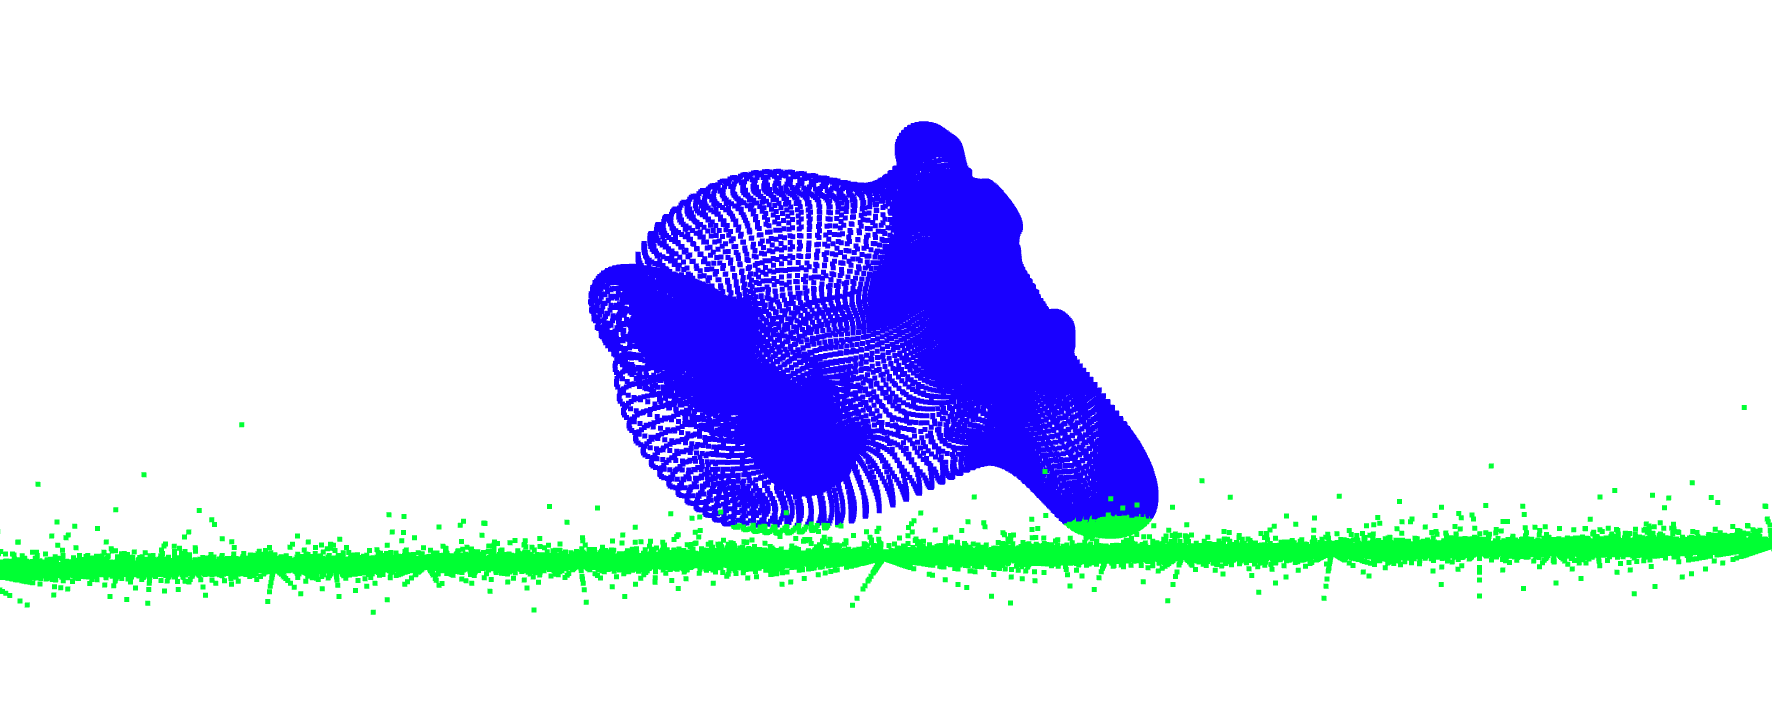

## Color-code object by its distance to the floor plane 

Now, let me not only calculate a minimal distance to the object:

In [154]:
obj = np.hstack(([xy[outlier_mask], z[outlier_mask].reshape(-1, 1)]))
obj.shape

(31033, 3)

In [155]:
print(obj)
distances = obj[:, 2] - np.mean(z[inlier_mask])
min_dist = distances.min()
max_dist = distances.max()
print(min_dist)
print(max_dist)

[[ 0.47888169 -0.35663345  0.2470662 ]
 [ 0.47714174 -0.36384735  0.23736972]
 [ 0.48358229 -0.35834619  0.23189092]
 ...
 [-0.68038887  0.22927949 -0.56934977]
 [-0.65964133  0.23103347 -0.56771386]
 [-0.63897783  0.23176916 -0.56646132]]
0.13026208610041445
1.5906409117649347


but also colour the object based on the distance to it:

In [156]:
norm_distances = (distances - min_dist) / (max_dist - min_dist)
obj_heatmap = np.array([1 - norm_distances, np.zeros_like(norm_distances), norm_distances]).T
obj_heatmap.shape

(31033, 3)

Running a visualisation for the last time:

In [157]:
pc_heatmap = o3d.geometry.PointCloud()
pc_heatmap.points = o3d.utility.Vector3dVector(obj)
pc_heatmap.colors = o3d.utility.Vector3dVector(obj_heatmap)
o3d.visualization.draw_geometries([pc_heatmap])

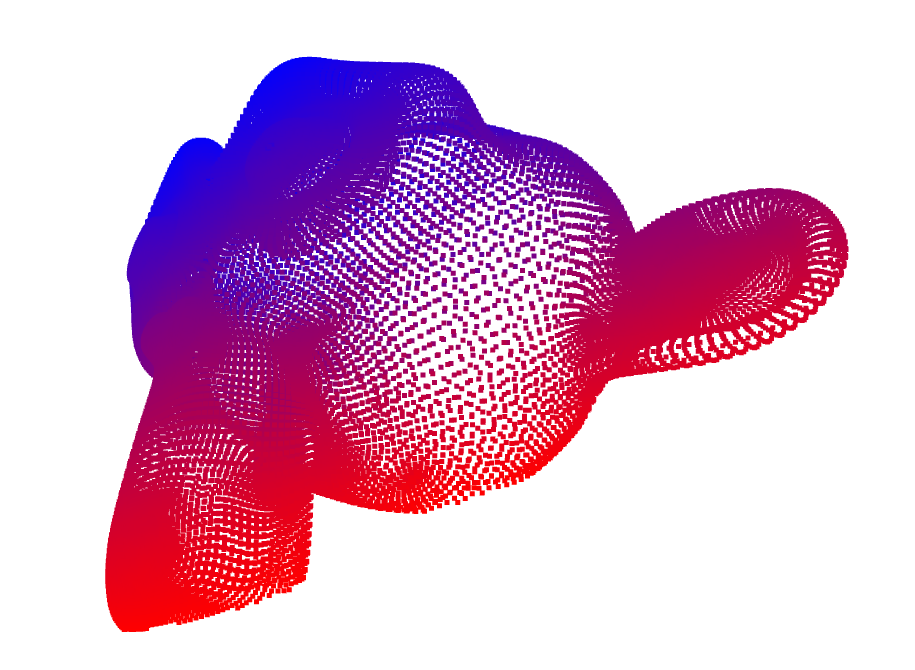